# Лабораторная работа №1

**Задание:** сгенерировать временной ряд (по приложенному генератору), отрисовать, провести классические статистические тесты, разложить на компоненты, построить ACF/PACF, выбрать статистический метод моделирования и обосновать выбор, сделать прогноз на разумный период, посчитать метрики и изобразить график прогноза с учетом ошибок (доверительный интервал).

Генератор временного ряда перенесён из приложенного файла (PDF).


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy.signal import periodogram
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import scripts_no_pandas as tsg

In [49]:
def detect_period(series):
    f, Pxx = periodogram(series)
    mask = f > 1/400 
    top_freq = f[mask][np.argmax(Pxx[mask])]
    return int(1 / top_freq)

def create_fourier_features(index, period, order=3):
    t = np.arange(len(index))
    X = pd.DataFrame({
        't': t,
        'log_t': np.log(t + 1),
        't_sq': t**2
    }, index=index)
    
    for k in range(1, order + 1):
        X[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        X[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return X

тип тренда: logarithmic


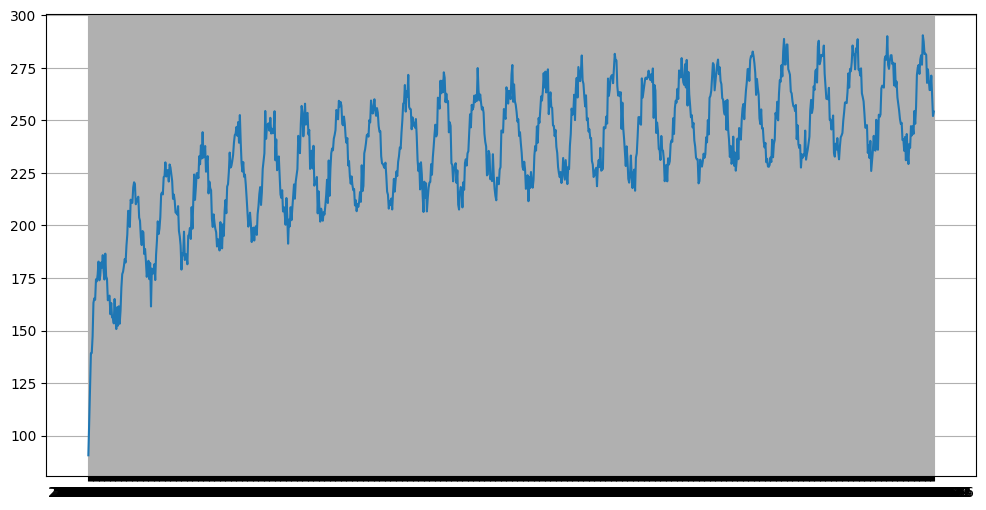

In [50]:
dates, values, trend_type = tsg.generate_time_series(n_points=1000, seed=42)
df = pd.DataFrame({'value': values}, index=dates)
print(f"тип тренда: {trend_type}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'])
plt.grid(True)
plt.show()

In [51]:
#cтатистические тесты

adf_res = adfuller(df['value'])
print(f"ADF Statistic: {adf_res[0]} (p-value: {adf_res[1]})")

kpss_res = kpss(df['value'], regression='ct', nlags='auto')
print(f"KPSS Statistic: {kpss_res[0]} (p-value: {kpss_res[1]})")

ADF Statistic: -4.565409543996062 (p-value: 0.0001495207928082543)
KPSS Statistic: 0.36376595555621155 (p-value: 0.01)


C:\Users\Firo\AppData\Local\Temp\ipykernel_42768\1308392411.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(df['value'], regression='ct')


доминирующий период: ~39 дней


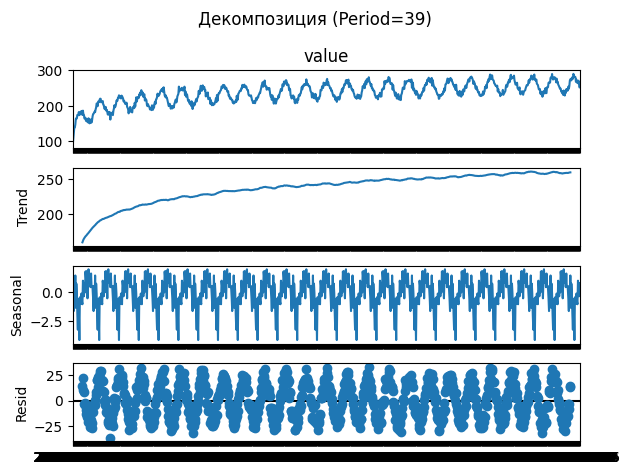

In [52]:
period = detect_period(df['value'].diff().dropna())
print(f"доминирующий период: ~{period} дней")

decomp = seasonal_decompose(df['value'], period=period, model='additive')
decomp.plot()
plt.suptitle(f'Декомпозиция (Period={period})')
plt.tight_layout()
plt.show()

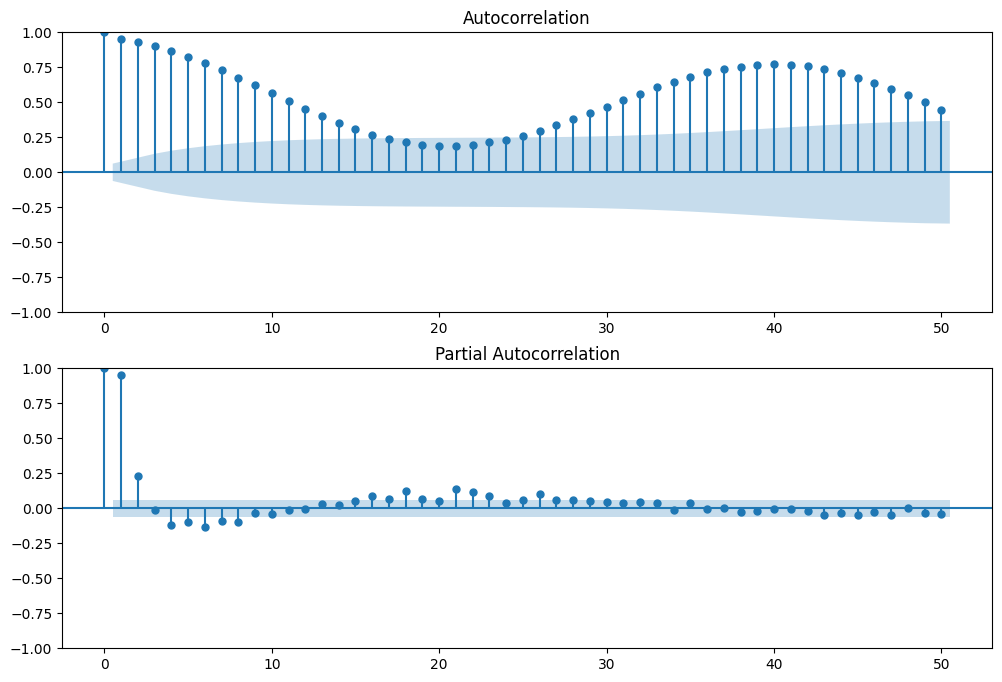

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['value'], lags=50, ax=ax1)
plot_pacf(df['value'], lags=50, ax=ax2)
plt.show()

Для моделирования данного ряда был выбран метод Dynamic Harmonic Regression. Линейная регрессия позволяет явно учесть наличие тренда через добавление признаков времени. тк доминирующий период 39 дней, то стандартные методы (например, SARIMA) могут быть сложны в настройке для таких длинных периодов. Разложение в ряд Фурье (sin/cos признаки) позволяет гибко и точно моделировать цикличность любой длины.

In [54]:
def detect_period(series):
    f, Pxx = periodogram(series)
    mask = f > 1/400 
    if not any(mask): return 1 
    top_freq = f[mask][np.argmax(Pxx[mask])]
    return int(round(1 / top_freq))


def create_features(index, period, order=3):
    t = np.arange(len(index))
    X = pd.DataFrame({
        't': t,
        'log_t': np.log(t + 1),
        't_sq': t**2
    }, index=index)
    
    for k in range(1, order + 1):
        X[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        X[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return X

In [55]:
period = detect_period(df['value'])
print(f"период сезонности: {period} дней")

период сезонности: 40 дней


In [56]:
X = create_features(df.index, period, order=3)
y = df['value']

test_size = period  
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

In [57]:
model = LinearRegression()
model.fit(X_train, y_train)

pred_test = model.predict(X_test)

mae = mean_absolute_error(y_test, pred_test)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mape = np.mean(np.abs((y_test - pred_test) / y_test)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

MAE: 15.941707500270109
RMSE: 18.31851499183634
MAPE: 6.243406211259073%


In [58]:
#обучаем на всех данных для прогноза
model_full = LinearRegression()
model_full.fit(X, y)

forecast_horizon = period * 2
last_date = df.index[-1]
future_dates = [pd.to_datetime(last_date).date() + timedelta(days=i) for i in range(1, forecast_horizon + 1)]

In [59]:
future_t = np.arange(len(X), len(X) + forecast_horizon)
X_future = pd.DataFrame({
    't': future_t,
    'log_t': np.log(future_t + 1),
    't_sq': future_t**2
}, index=future_dates)

for k in range(1, 4): 
    X_future[f'sin_{k}'] = np.sin(2 * np.pi * k * future_t / period)
    X_future[f'cos_{k}'] = np.cos(2 * np.pi * k * future_t / period)

forecast = model_full.predict(X_future)

In [60]:
residuals = y - model_full.predict(X)
std_resid = np.std(residuals)
ci_lower = forecast - 1.96 * std_resid
ci_upper = forecast + 1.96 * std_resid

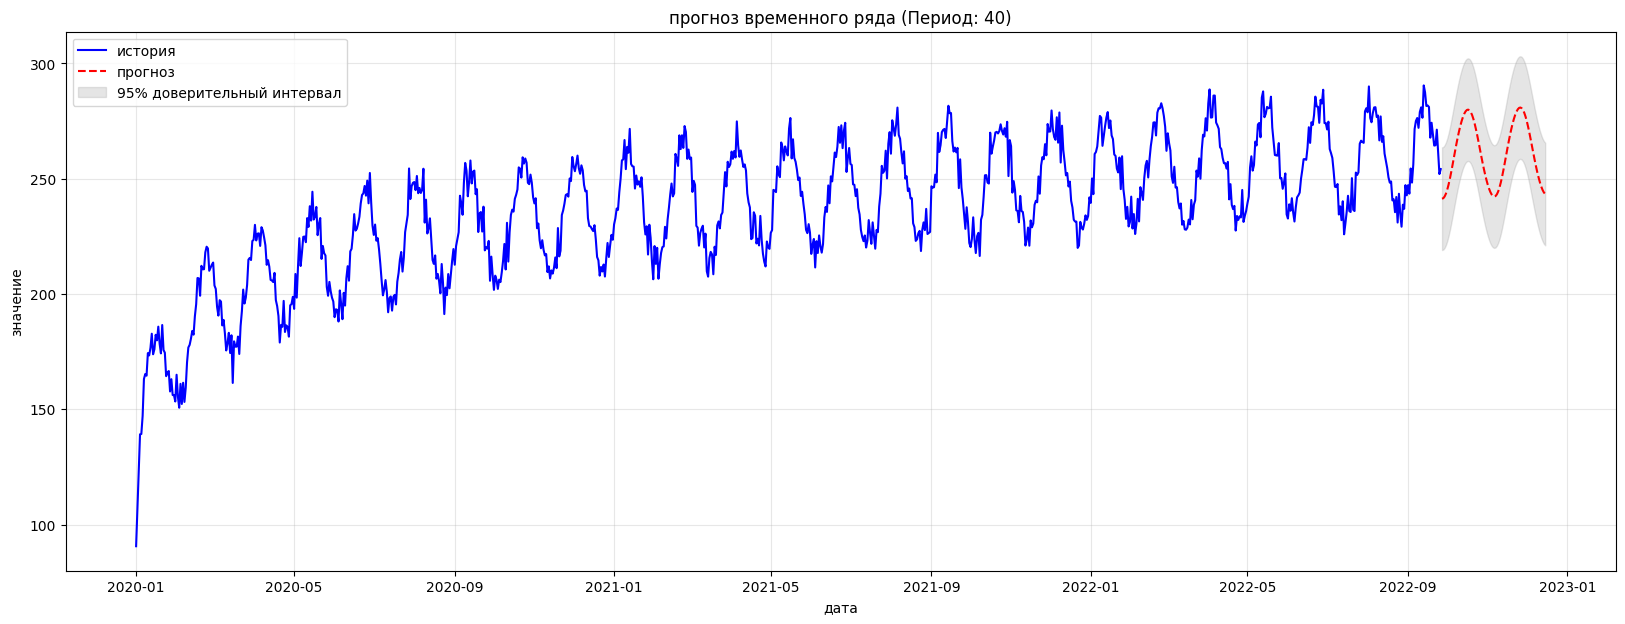

In [61]:
df.index = pd.to_datetime(df.index)
plt.figure(figsize=(20, 7))

plot_start = max(0, len(df) - 1000)
plt.plot(df.index[plot_start:], df['value'].iloc[plot_start:], label='история', color='blue')

plt.plot(future_dates, forecast, label='прогноз', color='red', linestyle='--')
plt.fill_between(future_dates, ci_lower, ci_upper, color='gray', alpha=0.2, label='95% доверительный интервал')

plt.title(f'прогноз временного ряда (Период: {period})')
plt.xlabel('дата')
plt.ylabel('значение')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()